In [15]:
import torch
import scvi
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.7.6 umap==0.5.3 numpy==1.19.4 scipy==1.6.2 pandas==1.3.3 scikit-learn==0.23.2 statsmodels==0.11.1 pynndescent==0.5.5


/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


## Data

Dataset curation at https://github.com/theislab/sc-pert/blob/main/datasets/Frangieh_2021.ipynb

In [74]:
# this dataset has already been filtered, and cells were removed which did not have
# a unique guide label as done in the original paper
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/sc-pert/datasets/Frangieh_2021.h5ad')
adata.obs['perturbation_name'] = ['_'.join(s.split('_')[:-1]) for s in adata.obs.sgRNA] # redo the dataset label because I wrote the regex wrong
adata

AnnData object with n_obs × n_vars = 126966 × 22097
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'n_genes', 'leiden', 'perturbation_name', 'perturbation_type', 'perturbation_value', 'perturbation_unit'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'MOI_colors', 'condition_colors', 'doi', 'hvg', 'leiden', 'leiden_colors', 'library_preparation_protocol_colors', 'neighbors', 'pca', 'perturbation_type_colors', 'perturbation_unit_colors', 'perturbation_value_colors', 'preprocessing_nb_link', 'protein_names', 'umap'
    obsm: 'X_pca', 'X_umap', 'protein_expression'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'perturbation_name' as categorical


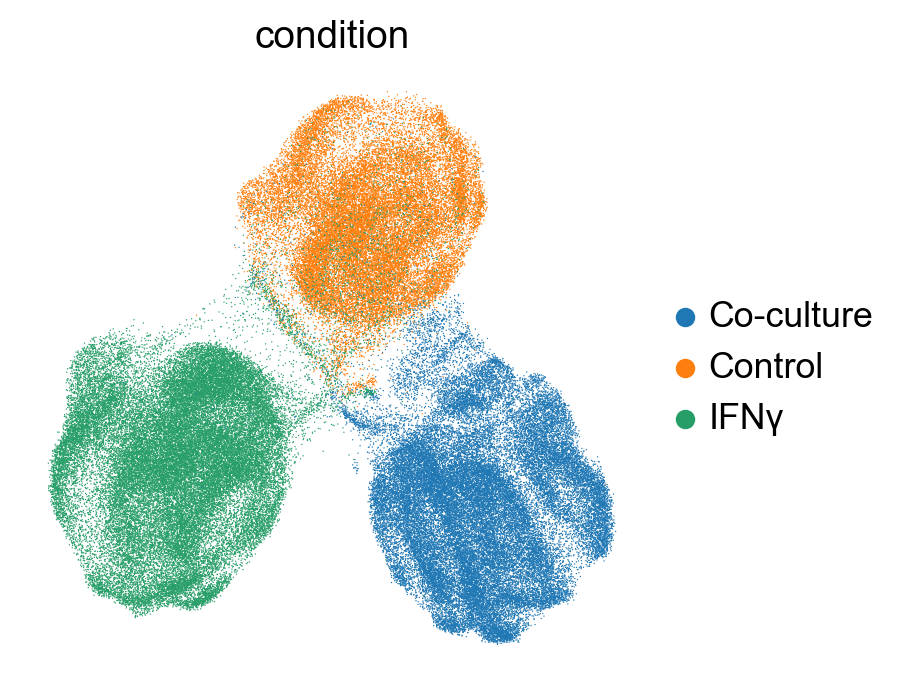

In [8]:
sc.pl.umap(adata, color='condition')

Subset to the control condition to avoid additional confounders to perturbation effect. It might be interesting to investigate the effects of IFNg treatment on feature attribution at a later date, but we'll leave it for now.

In [78]:
adata = adata[adata.obs.condition.isin(['Control'])]

In [79]:
sound_labels = adata.obs.perturbation_name.value_counts()[adata.obs.perturbation_name.value_counts() > 100].index
len(sound_labels)

176

In [80]:
missing_var = set(sound_labels) - set(adata.var_names)
missing_var

{'APOC2',
 'GAS5',
 'HLA-H',
 'LEF1-AS1',
 'LRRC75A-AS1',
 'NO_SITE',
 'NUP50-AS1',
 'ONE_NON-GENE_SITE',
 'SLC7A5P1',
 'SNHG6',
 'TYR',
 'WNT7A'}

164 out of 176. With the exception of WNT7A which was filtered out due to low expression levels, the other genes do not match those in `var_names` for various annotation regions.

Since we can't use these samples for feature attribution, we'll use them as a test set.

In [72]:
# craft test set
display(adata[adata.obs.perturbation_name.isin(missing_var)].obs.perturbation_name.value_counts())

NO_SITE              2189
ONE_NON-GENE_SITE    1581
NUP50-AS1             153
WNT7A                 149
LEF1-AS1              141
APOC2                 138
TYR                   133
HLA-H                 131
SLC7A5P1              125
LRRC75A-AS1           118
GAS5                  115
SNHG6                 112
Name: perturbation_name, dtype: int64

In [81]:
adata = adata[adata.obs.perturbation_name.isin(list(set(sound_labels) & set(adata.var_names)))].copy()

In [43]:
train = adata[adata.obs.perturbation_name.isin(list(set(sound_labels) & set(adata.var_names)))].copy()
train

AnnData object with n_obs × n_vars = 21757 × 22097
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'n_genes', 'leiden', 'perturbation_name', 'perturbation_type', 'perturbation_value', 'perturbation_unit'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'MOI_colors', 'condition_colors', 'doi', 'hvg', 'leiden', 'leiden_colors', 'library_preparation_protocol_colors', 'neighbors', 'pca', 'perturbation_type_colors', 'perturbation_unit_colors', 'perturbation_value_colors', 'preprocessing_nb_link', 'protein_names', 'umap'
    obsm: 'X_pca', 'X_umap', 'protein_expression'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [44]:
ood = adata[adata.obs.perturbation_name.isin(list(set(sound_labels) - set(adata.var_names)))].copy()
ood

AnnData object with n_obs × n_vars = 5085 × 22097
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'n_genes', 'leiden', 'perturbation_name', 'perturbation_type', 'perturbation_value', 'perturbation_unit'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'MOI_colors', 'condition_colors', 'doi', 'hvg', 'leiden', 'leiden_colors', 'library_preparation_protocol_colors', 'neighbors', 'pca', 'perturbation_type_colors', 'perturbation_unit_colors', 'perturbation_value_colors', 'preprocessing_nb_link', 'protein_names', 'umap'
    obsm: 'X_pca', 'X_umap', 'protein_expression'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Train

In [22]:
import scgen

In [82]:
# example: scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")
scgen.SCGEN.setup_anndata(train, labels_key='perturbation_name')

In [59]:
model = scgen.SCGEN(adata)
model.module

SCGENVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=22097, out_features=800, bias=True)
          (1): BatchNorm1d(800, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.2, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=800, out_features=800, bias=True)
          (1): BatchNorm1d(800, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=800, out_features=100, bias=True)
    (var_encoder): Linear(in_features=800, out_features=100, bias=True)
  )
  (decoder): DecoderSCGEN(
    (decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequentia

Parameters taken from the scGen tutorial.

In [32]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/torch/distributed/_sharded_tensor/__init__.py:10: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  DeprecationWarning
/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potent

Epoch 271/368:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 270/368 [1:23:34<30:53, 18.92s/it, loss=1.59e+04, v_num=1]

/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


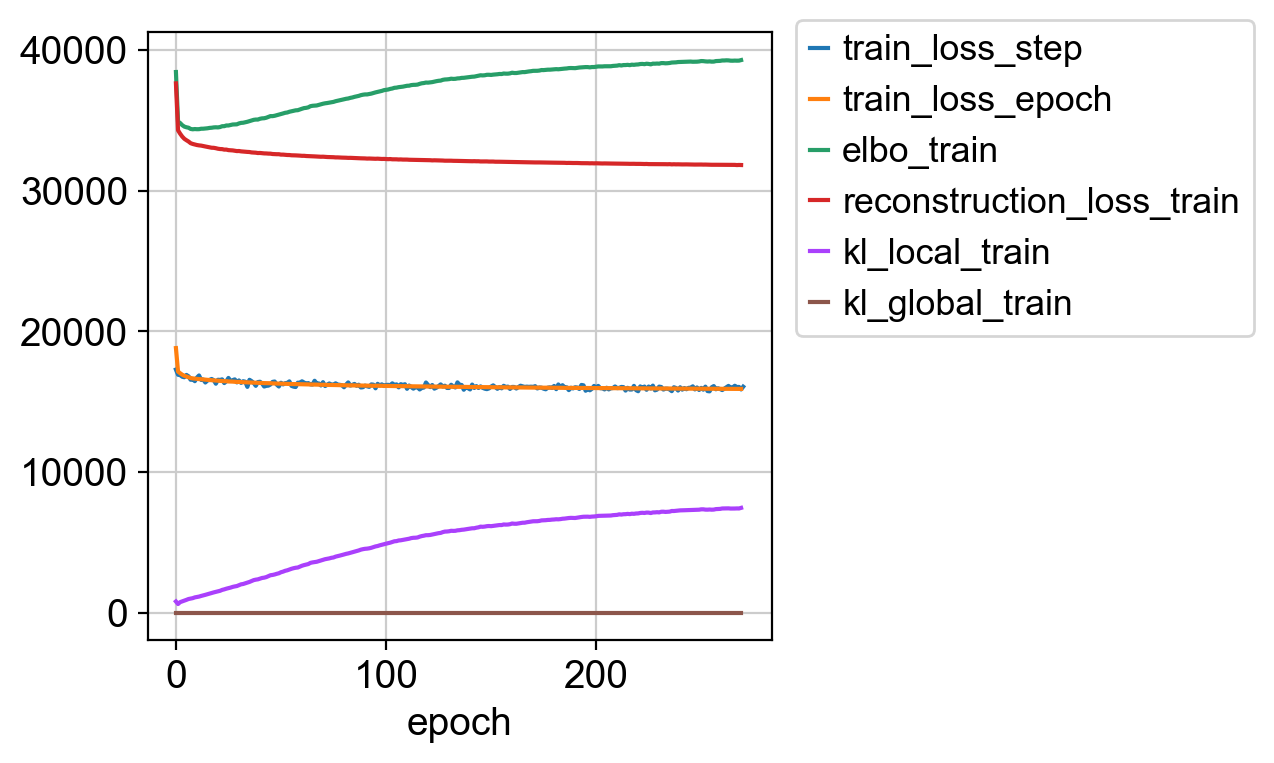

In [58]:
pd.concat(model.history.values(), axis=1).plot()
plt.legend(bbox_to_anchor=(1.01, 1.05));

Latent space visualization.

In [ ]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())